# **White Wine Quality Data Set Exploratory Analysis**

**Importing Libraries**

In [57]:
# Init
!test -e ds-assets && cd ds-assets && git pull && cd ..
!test ! -e ds-assets && git clone https://github.com/IndraniMandal/ds-assets.git
home = "ds-assets/assets/"
import sys
sys.path.append(home)

# Data manipulation and analysis
import pandas as pd
import numpy as np
import shap
import xgboost

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Evaluation metrics
from sklearn.metrics import accuracy_score
import scipy.stats as stats

Already up to date.


**Importing Data Set**

In [58]:
url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/refs/heads/master/winequality-white.csv'
df = pd.read_csv(url)

# Finding dataset size
num_rows, num_columns = df.shape

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 4898
Number of Columns: 12


The dataset includes the following features:
1.   **Fixed Acidity:** Concentration of non-volatile acids (tartaric acid, for example).
2.   **Volatile Acidity:** Amount of acetic acid in the wine, which can affect the aroma.
3.   **Citric Acid:** Small amounts of citric acid can add freshness and flavor.
4.   **Residual Sugar:** Sugar remaining after fermentation stops.
5.   **Chlorides:** Concentration of salt in the wine.
6.   **Free Sulfur Dioxide:** The amount of SO2 that is not bound and can act as an antimicrobial agent.
7.   **Total Sulfur Dioxide:** Total SO2 present, free and bound.
8.   **Density:** The density of the wine, typically close to water density.
9.   **pH:** Measure of how acidic or basic the wine is.
10.  **Sulphates:** A wine additive that can contribute to SO2 levels and acts as an antioxidant.
11.  **Alcohol:** Alcohol content in the wine (% by volume).

Target:
*   **Quality:** The quality rating of the wine ranging from 1 to 9.

**Data Cleaning and Preprocessing**

In [59]:
# Checking if any values are null
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [60]:
# Loop over the columns and check for non-numeric values
for column in df.columns:
    # Ignore non-numeric columns
    if df[column].dtype != 'object':
        non_numeric = pd.to_numeric(df[column], errors='coerce').isnull().sum()
        if non_numeric > 0:
            print(f"Column '{column}' contains {non_numeric} non-numeric values.")

# Check if the target values fall within expected range
if df['quality'].min() < 1 or df['quality'].max() > 9:
    print("Warning: Some values in 'quality' are outside the expected range (1-9).")

**Data Set Value Analysis**

In [61]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

The dataset contains 4,898 samples with 12 features describing the physicochemical properties and quality of wine. Below is a concise analysis of each attribute:


1.   **Fixed Acidity:**
    *   Mean: 6.85, Standard Deviation: 0.84
    *   Range: 3.80 (min) to 14.20 (max).
    *   Most values lie between 6.30 (25th percentile) and 7.30 (75th percentile).
2.   **Volatile Acidity:**
    *   Mean: 0.28, Standard Deviation: 0.10
    *   Range: 0.08 (min) to 1.10 (max).
    *   Typically between 0.21 and 0.32, indicating a low level of acidity.
3.   **Citric Acid:**
    *   Mean: 0.33, Standard Deviation: 0.12
    *   Range: 0.00 (min) to 1.66 (max).
    *   Most samples have citric acid levels between 0.27 and 0.39.
4.   **Residual Sugar:**
    *   Mean: 6.39, Standard Deviation: 5.07
    *   Range: 0.60 (min) to 65.80 (max).
    *   The distribution is skewed, with most values between 1.70 and 9.90.
5.   **Chlorides:**
    *   Mean: 0.045, Standard Deviation: 0.022
    *   Range: 0.009 (min) to 0.346 (max).
    *   Typical chloride content ranges from 0.036 to 0.050.
6.   **Free Sulfur Dioxide:**
    *   Mean: 35.31, Standard Deviation: 17.01
    *   Range: 2.00 (min) to 289.00 (max).
    *   Concentrations are generally between 23.00 and 46.00.
7.   **Total Sulfur Dioxide:**
    *   Mean: 138.36, Standard Deviation: 42.50
    *   Range: 9.00 (min) to 440.00 (max).
    *   Most values lie between 108.00 and 167.00.
8.   **Density:**
    *   Mean: 0.994, Standard Deviation: 0.003
    *   Range: 0.987 (min) to 1.039 (max).
    *   Densities cluster tightly, reflecting consistency in wine composition.
9.   **pH:**
    *   Mean: 3.19, Standard Deviation: 0.15
    *   Range: 2.72 (min) to 3.82 (max).
    *   Most wines have a pH between 3.09 and 3.28, indicating mild acidity.
10.   **Sulphates:**
    *   Mean: 0.49, Standard Deviation: 0.11
    *   Range: 0.22 (min) to 1.08 (max).
    *   Concentrations typically range from 0.41 to 0.55.
11.   **Alcohol:**
    *   Mean: 10.51, Standard Deviation: 1.23
    *   Range: 8.00 (min) to 14.20 (max).
    *   Alcohol levels are concentrated between 9.50 and 11.40.
12.   **Quality:**
    *   Mean: 5.88, Standard Deviation: 0.89
    *   Range: 3.00 (min) to 9.00 (max).
    *   The majority of samples fall within a quality rating of 5 to 6.

**Insights:**
*   The dataset exhibits a diverse range in attributes like residual sugar, sulfur dioxide levels, and alcohol content.
*   Quality scores (3 to 9) are slightly skewed, with most samples rated around 5 or 6, which suggests room for exploring relationships between physicochemical properties and quality ratings.
*   Features like pH, density, and chlorides are tightly distributed, indicating standardization in these wine production aspects.



# **Data exploratory analysis by use of visualization**

**Histogram and Outlier Detection**

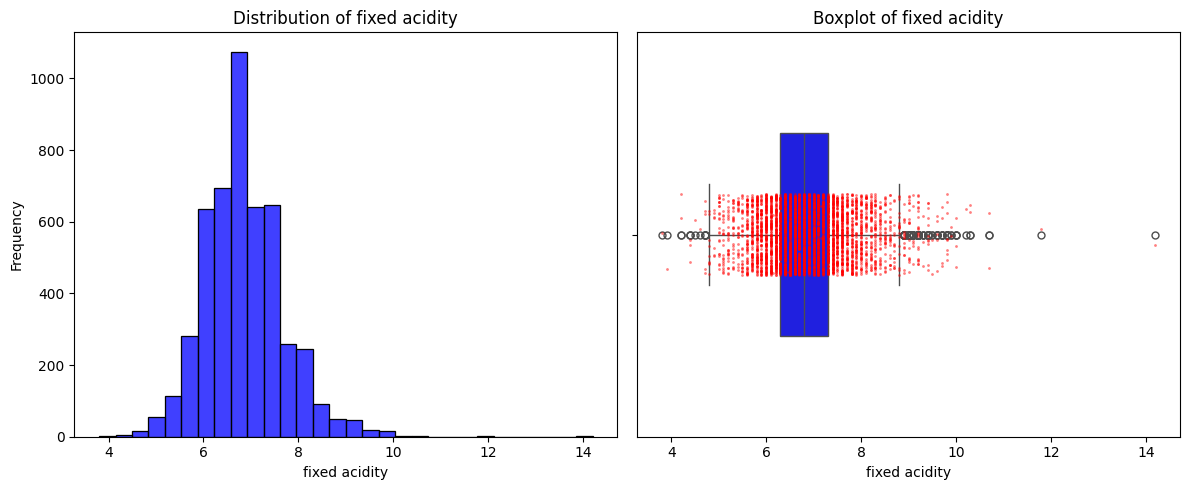

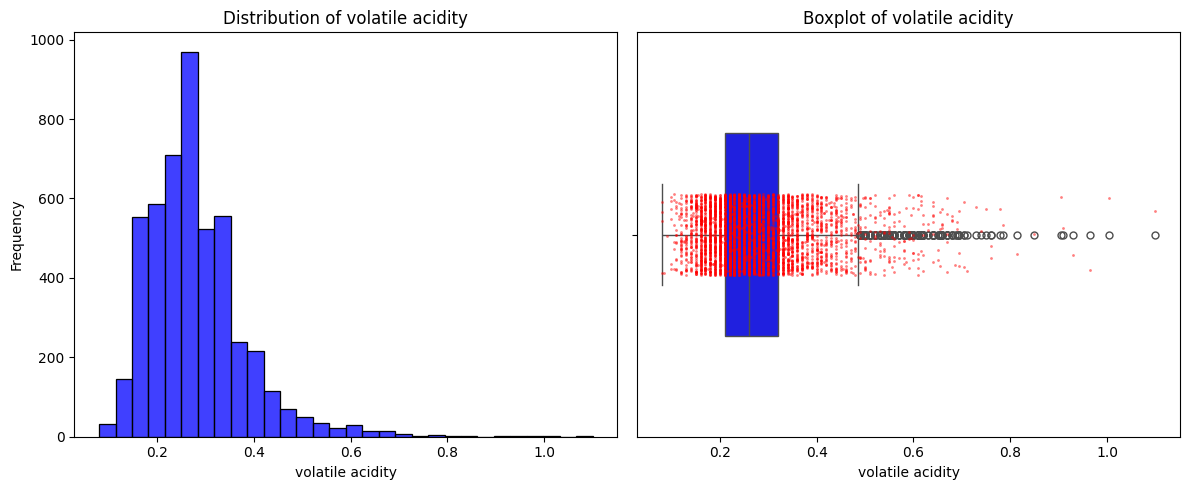

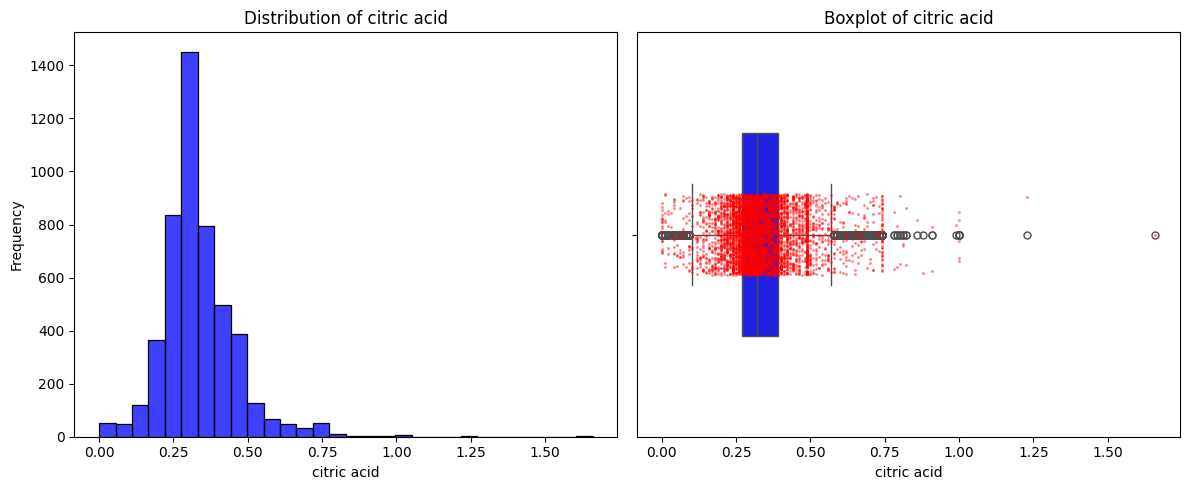

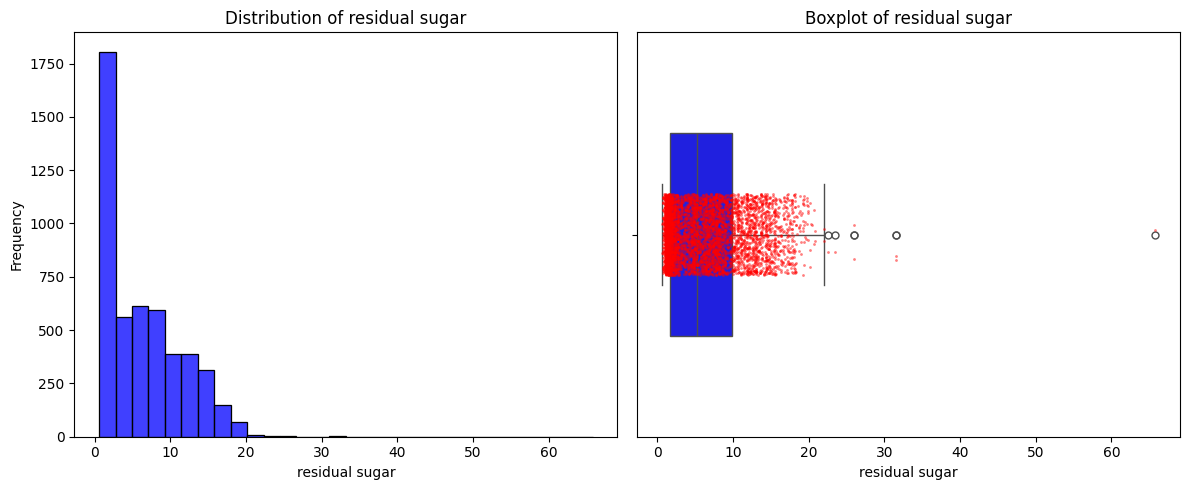

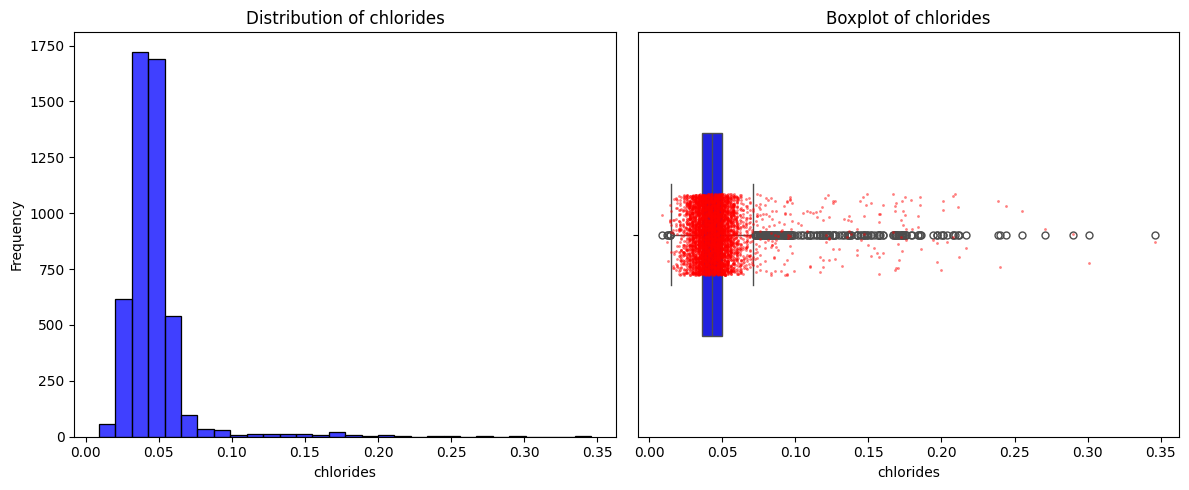

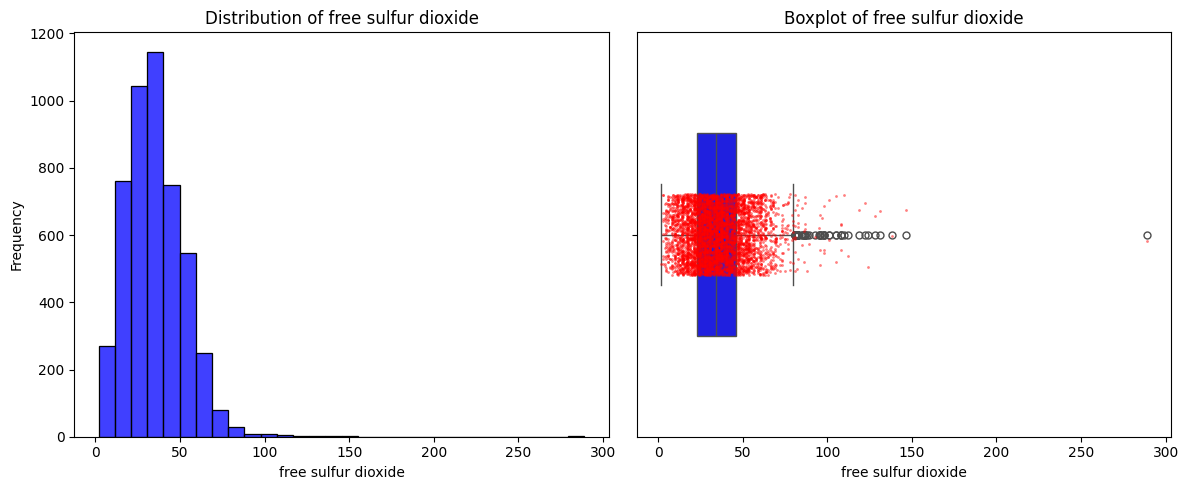

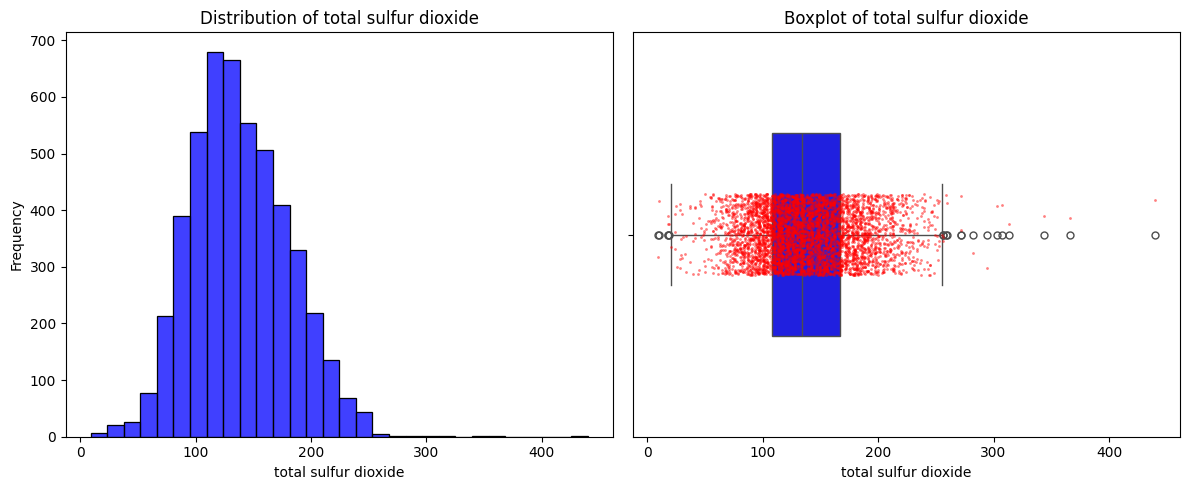

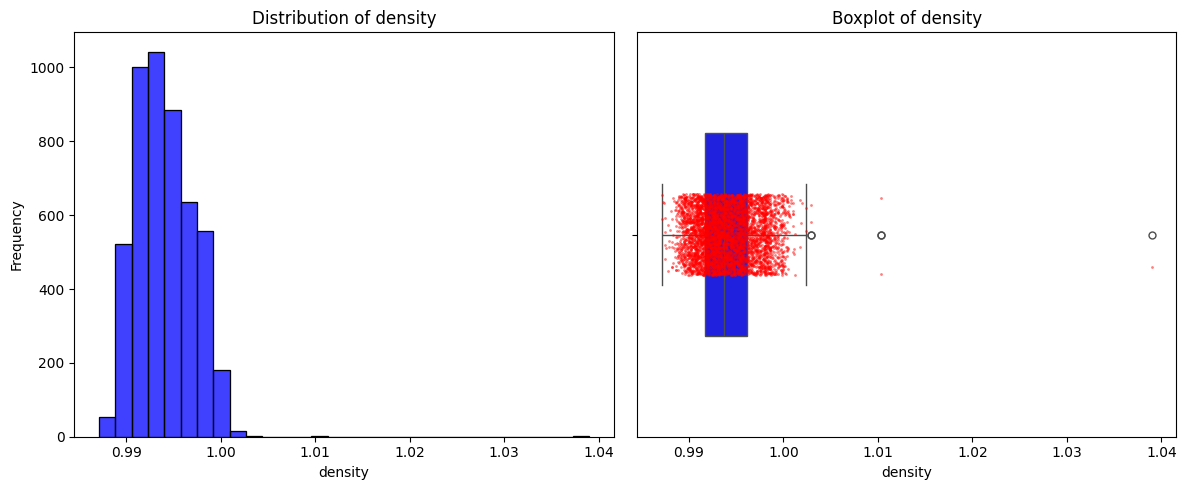

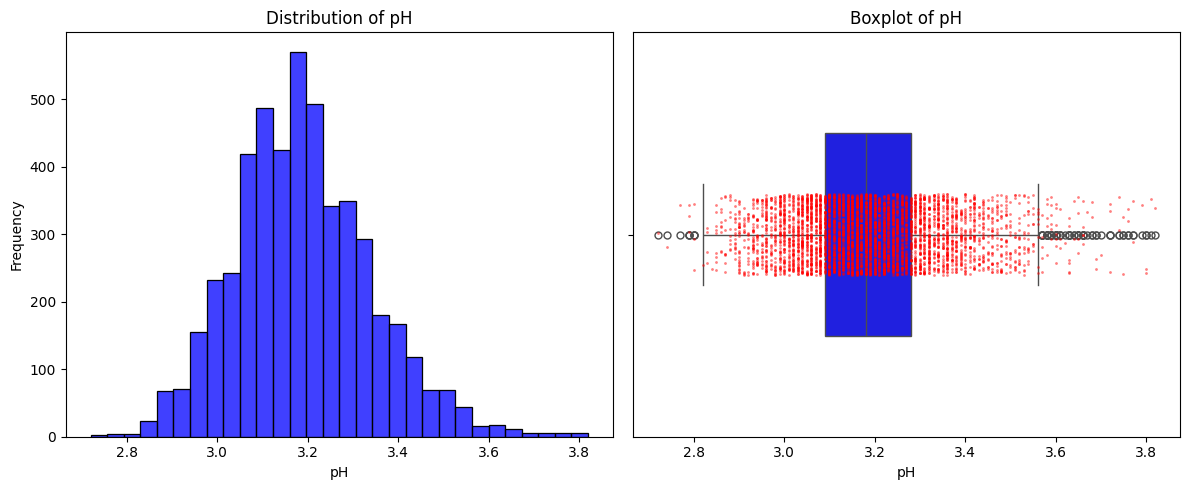

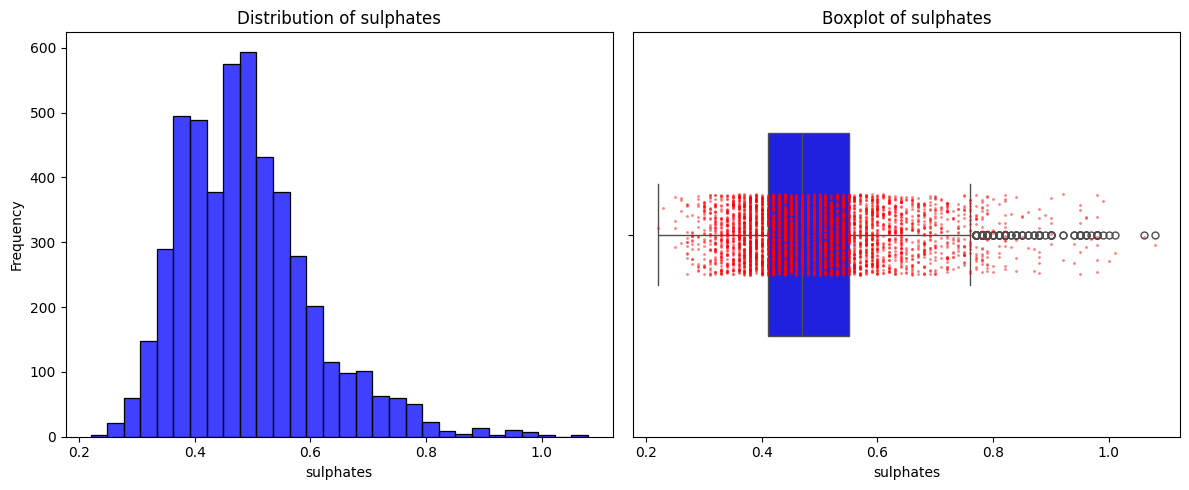

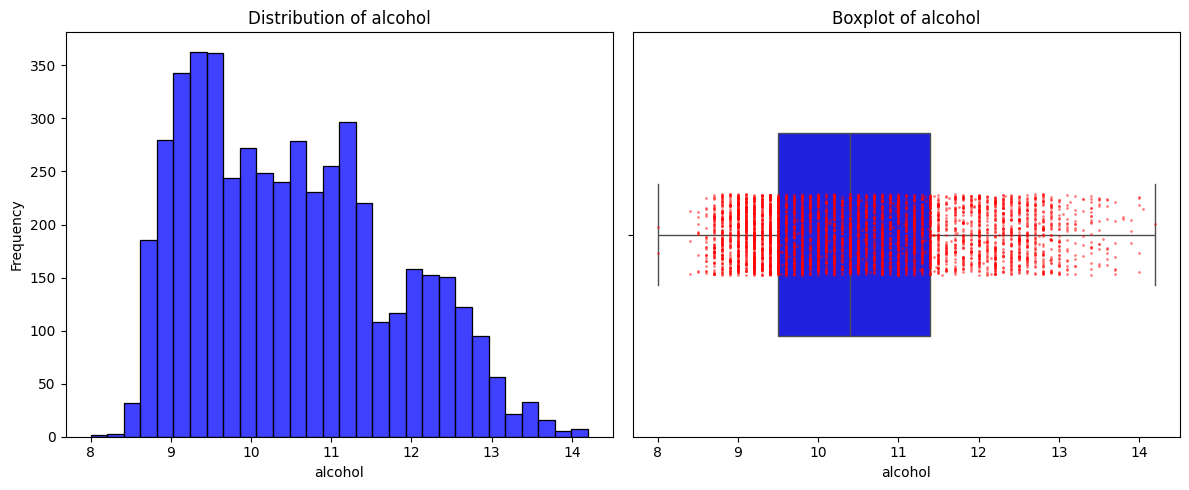

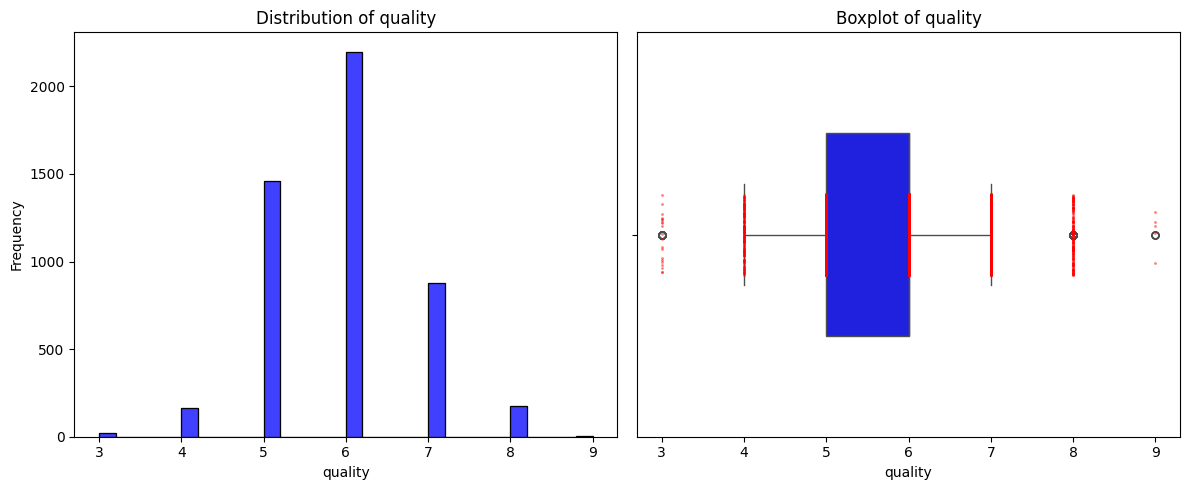

In [62]:
# Create a list of columns to visualize (excluding non-numeric or unnecessary columns)
columns = df.columns

# Loop through each column to plot
for column in columns:
    # Set figure size
    plt.figure(figsize=(12, 5))

    # Bar plot for distribution
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=column, kde=False, bins=30, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Box plot with black outliers and red data points
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x=column, color='blue', width=0.5, flierprops={'marker': 'o', 'color': 'black', 'markersize': 5})
    sns.stripplot(data=df, x=column, color='red', alpha=0.5, jitter=True, size=2)
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

    # Display the plots
    plt.tight_layout()
    plt.show()

**Anaylsis**

1.   **Fixed Acidity:** The fixed acidity distribution is roughly normal, with most values concentrated between 6 and 8 and peaking around 7. The boxplot confirms this central tendency but highlights outliers below 4 and above 10, indicating occasional deviations from the norm.
2.   **Volatile Acidity:** The volatile acidity distribution is right-skewed, with most values between 0.2 and 0.4 and a peak around 0.2. The boxplot reflects this, showing a compact IQR with outliers above 0.6, suggesting a small subset of wines with unusually high volatile acidity.
3.   **Citric Acid:** The citric acid distribution is also right-skewed, with most values falling between 0.0 and 0.3, peaking near 0.25. The boxplot confirms this trend, with outliers above 0.75, indicating rare instances of higher citric acid content.
4.   **Residual Sugar:** The residual sugar distribution is highly right-skewed, with most values concentrated below 10 and a sharp decline in frequency as values increase. The boxplot confirms this skewness, showing a compact interquartile range and multiple outliers above 20, indicating occasional extreme values.
5.   **Chlorides:** The chlorides distribution is heavily right-skewed, with most values clustered between 0.04 and 0.06, and a steep drop-off beyond this range. The boxplot illustrates a narrow interquartile range with numerous outliers extending above 0.1, indicating occasional high concentrations.
6.   **Free Sulfur Dioxide:**
The free sulfur dioxide distribution is right-skewed, with most values concentrated between 0 and 50, and a gradual decline beyond this range. The boxplot reveals a compact interquartile range with several outliers extending above 100, indicating occasional high levels in the data.
7.   **Total Sulfuer Dioxide:** The histogram reveals a right-skewed distribution, with most values clustered between 50 and 150 and fewer higher values extending to around 400. The boxplot confirms this skewness, with a concentrated interquartile range and numerous outliers beyond the upper whisker, suggesting a non-normal distribution and significant variability in the data.
8.   **Density:** The histogram indicates a left-skewed distribution, with most values tightly concentrated between 0.99 and 1.00, and a small number of higher values extending up to 1.04. The boxplot highlights a narrow interquartile range and a few outliers beyond the whiskers, reflecting a dataset with low variability and slight asymmetry.
9.   **pH:** The histogram reveals a roughly symmetrical distribution centered around 3.2, indicating a normal-like shape with most values between 3.0 and 3.4. The boxplot supports this observation, showing a balanced interquartile range with outliers on both sides, highlighting slight variability but no extreme skewness in the data.
10.  **Sulphates:** The histogram on the left shows a right-skewed distribution with most sulphate concentrations ranging between 0.4 and 0.6, peaking around 0.5. The boxplot on the right highlights this central tendency, showing a median near 0.5 and an interquartile range concentrated between approximately 0.4 and 0.6. Numerous outliers are visible beyond the whiskers, particularly on the higher end, indicating occasional high sulphate levels in the dataset.
11.  **Alcohol:** The histogram on the left shows a slightly right-skewed distribution, with most alcohol values ranging between 9 and 12, peaking around 10.5. The boxplot on the right confirms this central tendency, with a median close to 10.5 and an interquartile range between approximately 9.8 and 11.2. There are a few outliers visible on both the lower and higher ends, but they are less pronounced compared to the central bulk of the data.

**Correlation of Dataset Features**

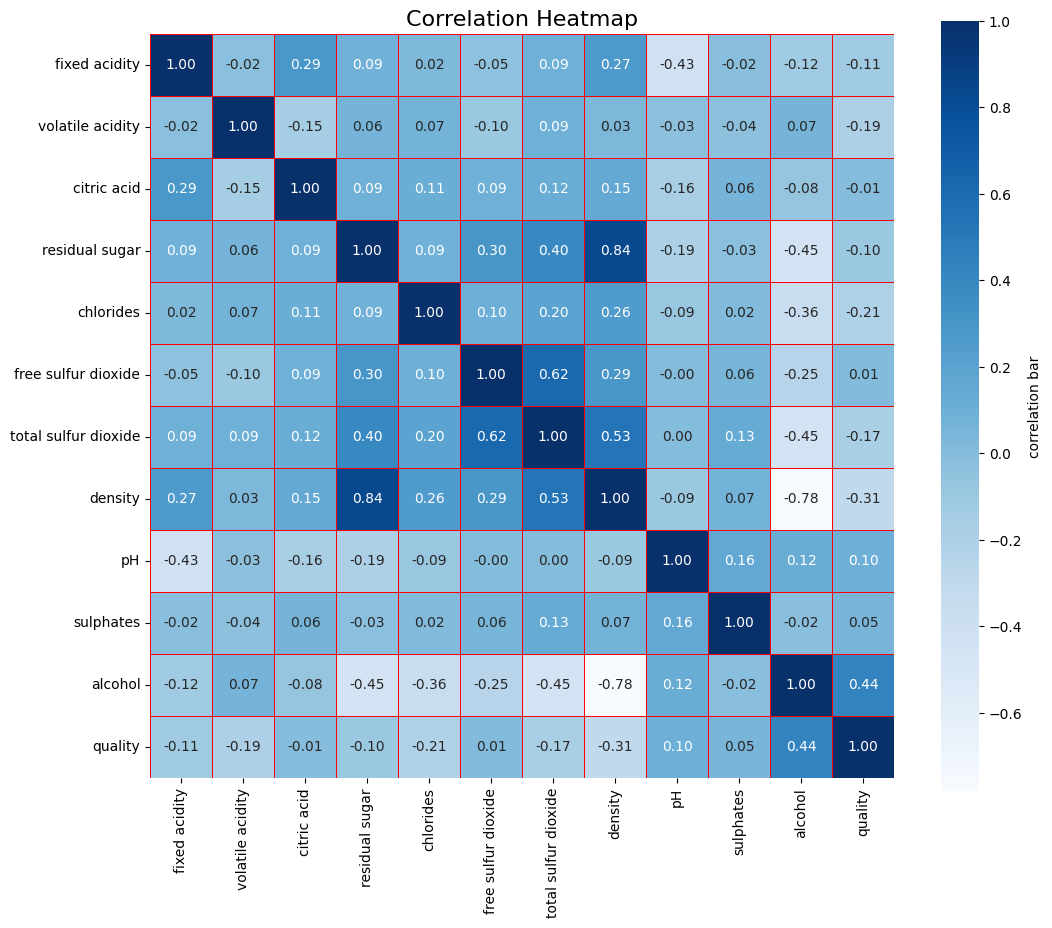

In [63]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True,
    linewidths=0.5,
    linecolor="red",
    cbar_kws={'label': 'correlation bar'}
)

# Add a title
plt.title("Correlation Heatmap", fontsize=16)

# Show the plot
plt.show()

**Scatter Matrix**

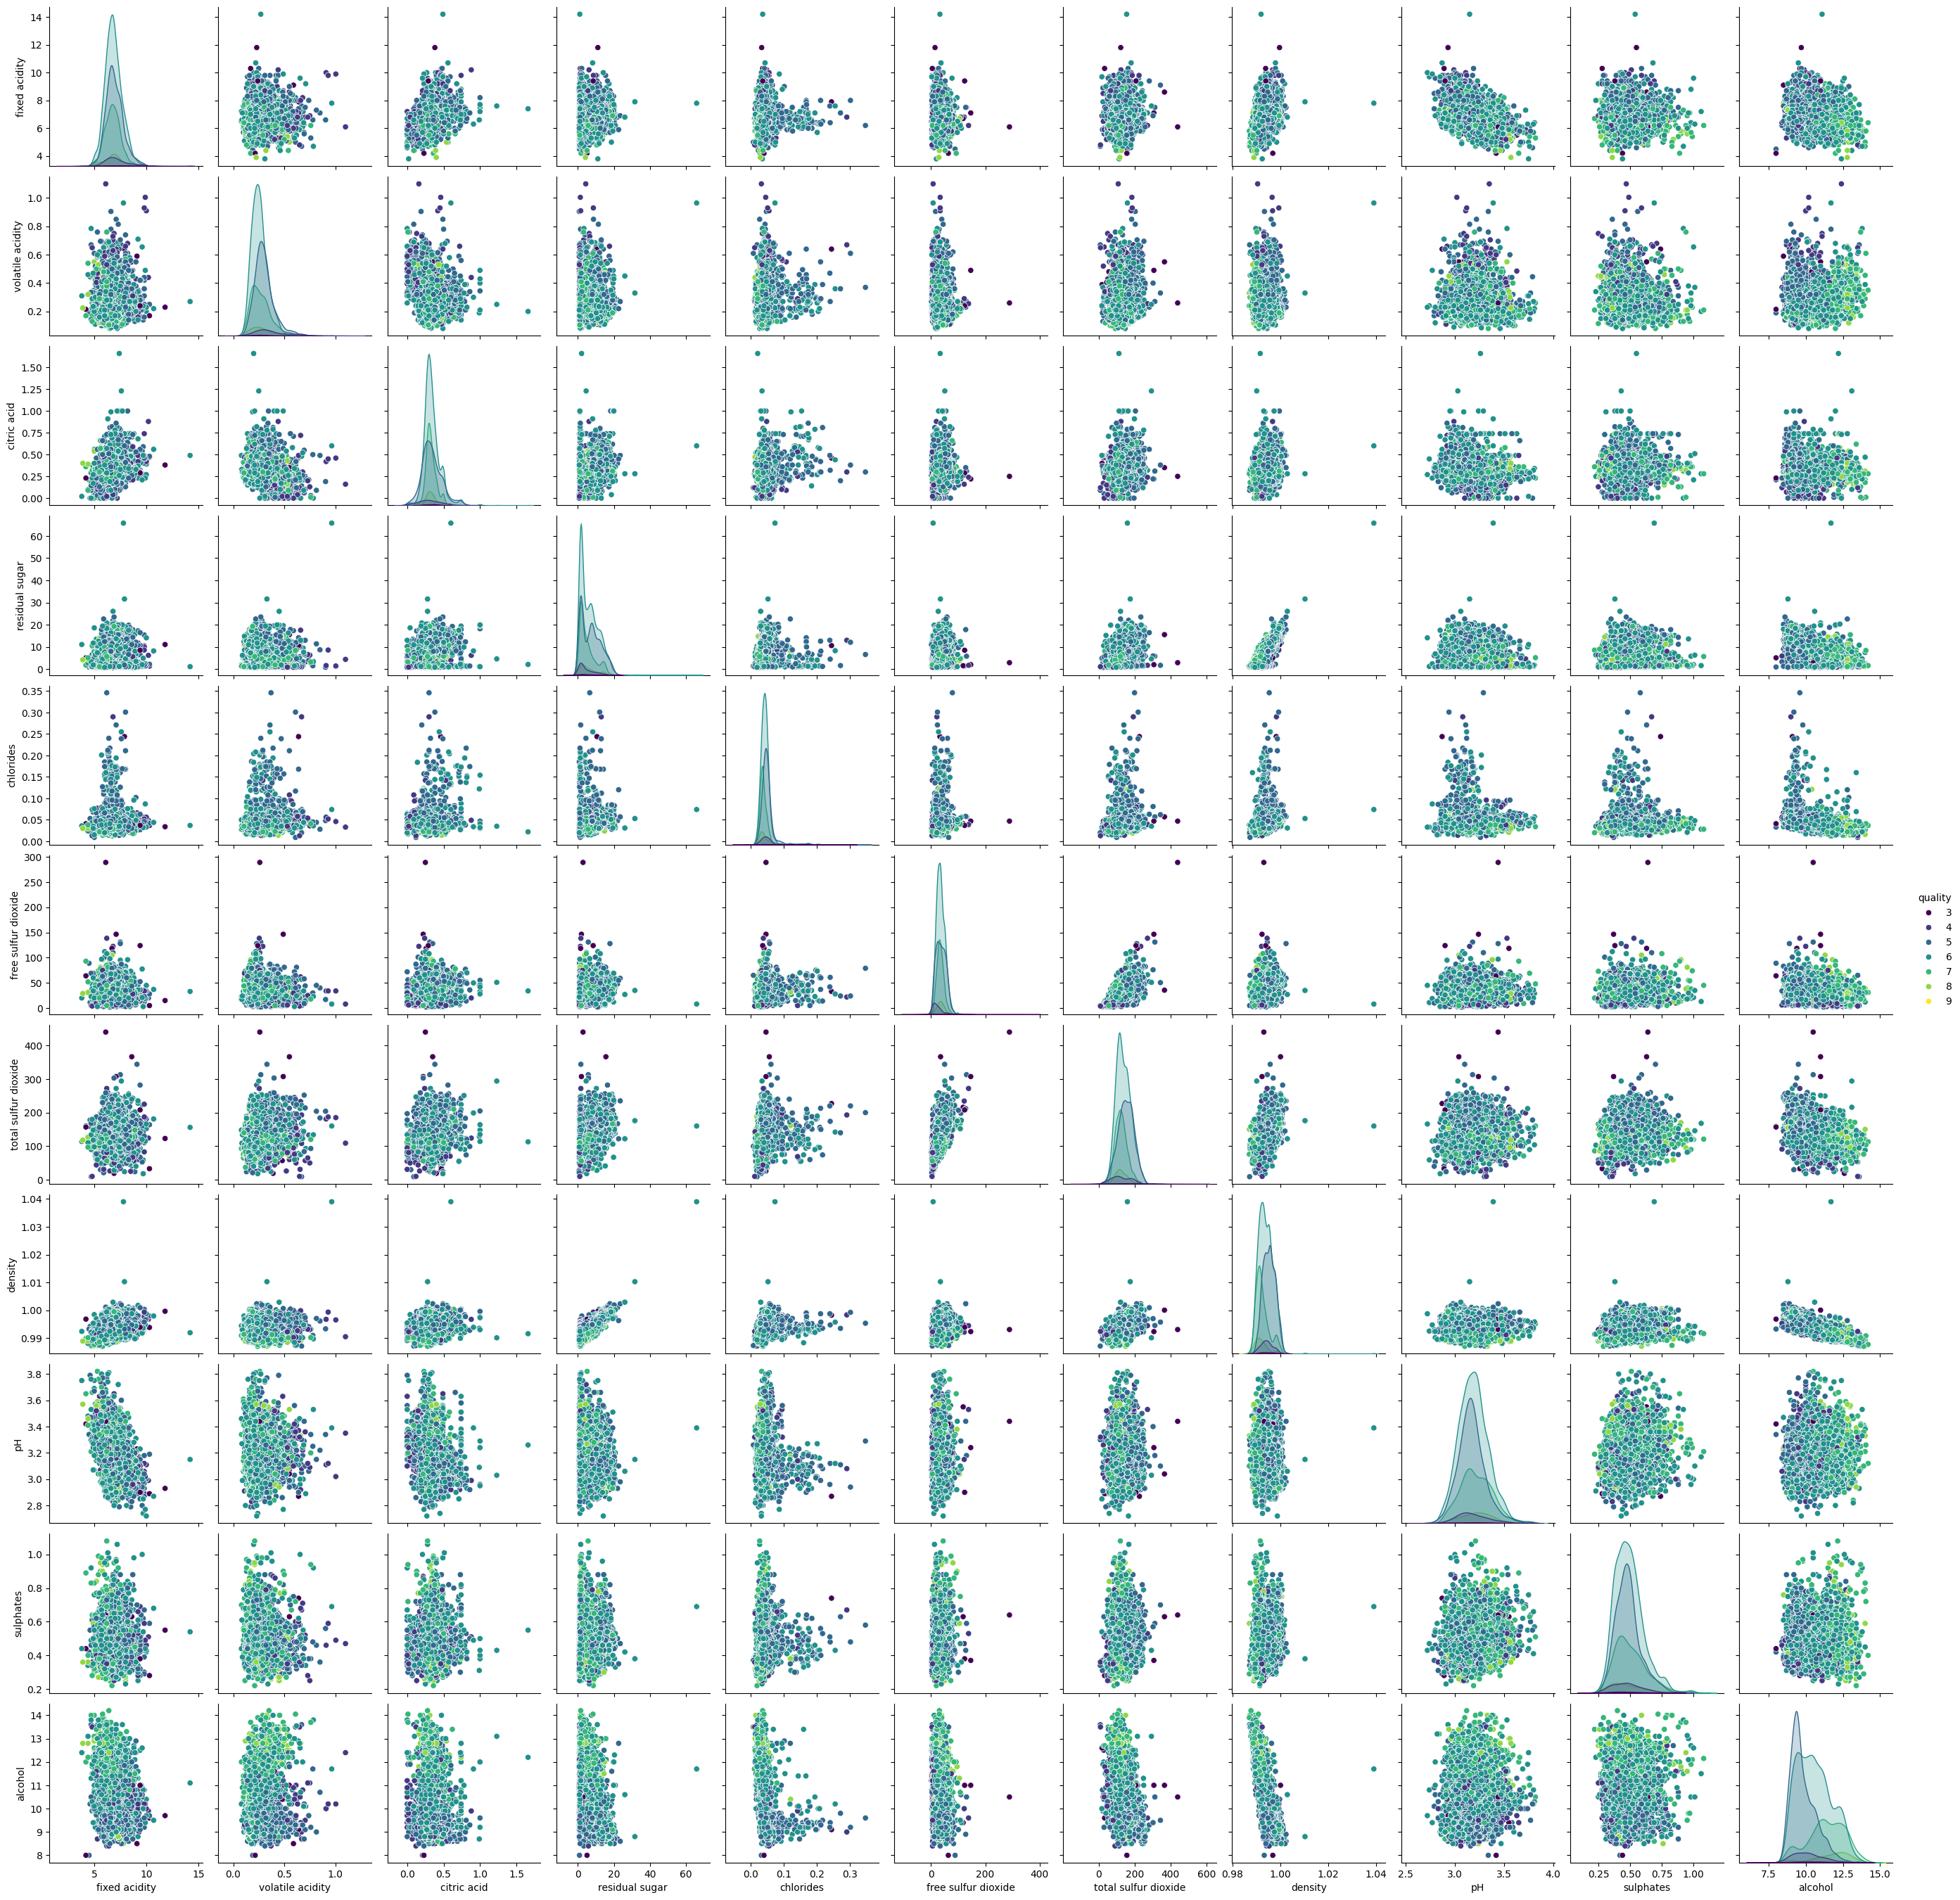

In [64]:
# Create the scatter matrix using seaborn and color by 'quality'
sns.pairplot(df, hue='quality', palette='viridis')

# Display the plot
plt.show()

**Anaylsis**

The scatter matrix offers a detailed visualization of the relationships between multiple variables in the dataset, combining pairwise scatter plots and diagonal histograms to provide both inter-variable and individual variable insights. The histograms along the diagonal reveal the distribution of each variable, with some showing symmetric, bell-shaped distributions and others displaying skewness or the presence of outliers. The scatter plots depict pairwise relationships, where trends, such as linear or non-linear correlations, can be identified in some variable pairs, while others show no apparent relationship. Notably, the points are color-coded by the categorical variable "quantity," enabling the observation of how different categories distribute across variable pairs. This highlights potential groupings or patterns, with some scatter plots indicating distinct clusters or separations among categories, while others show significant overlap, suggesting limited discriminatory power between those variables. Outliers and extreme values are also evident in several plots, which may require further investigation. Overall, this scatter matrix provides a rich, visual summary of the dataset, facilitating the identification of correlations, patterns, distributions, and categorical distinctions for deeper analysis.

**Count Plot of Target Variable**

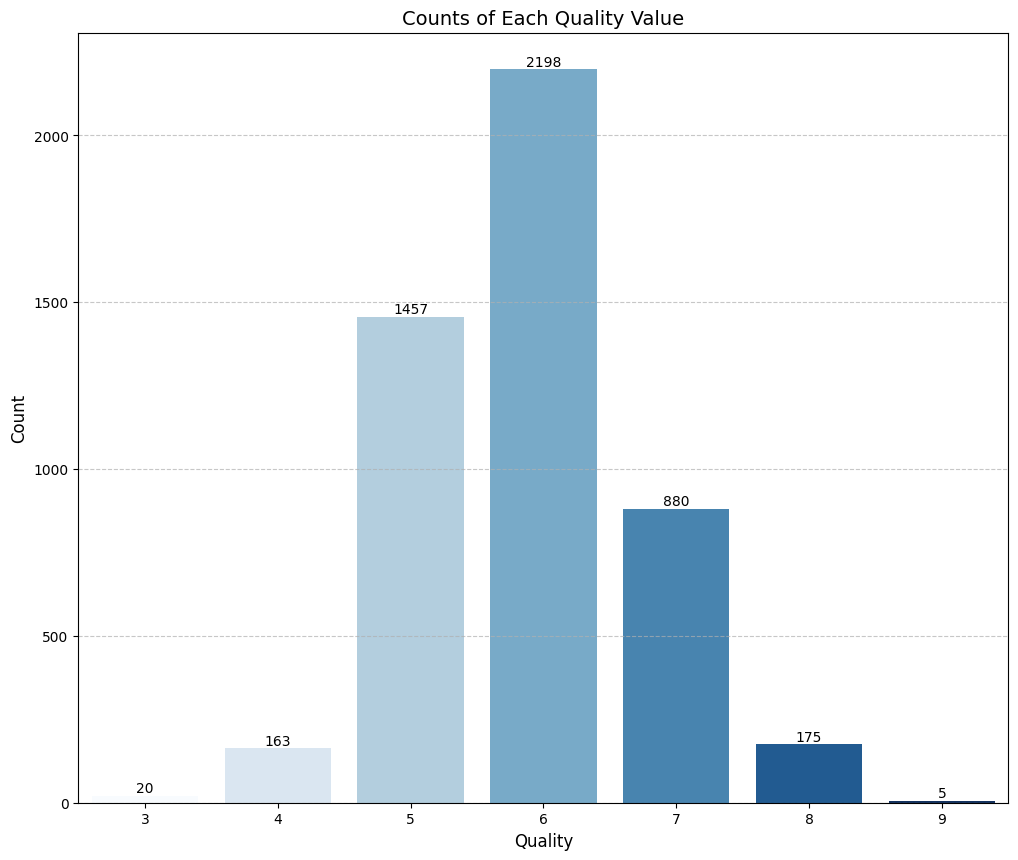

In [65]:
# Count the occurrences of each unique value in 'quality'
quality_counts = df['quality'].value_counts().sort_index()

# Plot the bar graph
plt.figure(figsize=(12, 10))
sns.barplot(
    x=quality_counts.index,
    y=quality_counts.values,
    palette="Blues",
    hue=quality_counts.index,
    dodge=False,
    legend=False
)

# Add annotations (counts) on top of each bar
for index, value in enumerate(quality_counts.values):
    plt.text(index, value + 10, str(value), ha='center', fontsize=10, color='black')

# Add titles and labels
plt.title('Counts of Each Quality Value', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Hypothesis Based on Exploratory Anaylsis**

**Hypothesis:** The quality of wine is influenced by a combination of physicochemical properties, with specific attributes such as alcohol content, volatile acidity, and residual sugar playing key roles. Higher alcohol content and balanced acidity (fixed and volatile) are likely to correlate positively with quality, while extreme levels of residual sugar, sulfur dioxide, or chlorides may negatively impact it due to their association with outlier or skewed distributions. Additionally, consistent features like pH and density may have a stabilizing effect on quality, ensuring wines stay within an acceptable standard.

This hypothesis is supported by the following observations:

1.   **Alcohol Content:** The slightly right-skewed distribution with a mean around 10.5 and peaks at higher quality ratings suggests that moderate to high alcohol levels are preferred.
2.   **Volatile Acidity:** The compact IQR centered around lower values and the presence of high outliers indicate that excessive acidity may reduce quality.
3.   **Residual Sugar and Sulfur Dioxide:** The highly skewed distributions and significant outliers in these features suggest that extreme deviations might negatively influence quality, indicating that balance is crucial.
4.   **pH and Density:** Their tightly distributed and near-normal shapes indicate these features remain relatively stable, which may contribute to producing wines of consistent quality.

# **Predictive Analysis**

**Preliminary Model Building**

In [66]:
X = df.drop('quality', axis=1)
y = df['quality']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

**Low Complexity Model**

In [67]:
param_grid_simple = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None]
}

grid_search_simple = GridSearchCV(estimator=dt, param_grid=param_grid_simple, cv=5, n_jobs=-1, verbose=2)
grid_search_simple.fit(X_train, y_train)
print(f"Best parameters (Low Complexity Model): {grid_search_simple.best_params_}")
best_dt_simple = grid_search_simple.best_estimator_
y_pred_simple = best_dt_simple.predict(X_test)
test_accuracy_simple = accuracy_score(y_test, y_pred_simple)
print(f"Test accuracy (Low Complexity Model): {test_accuracy_simple:.2f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters (Low Complexity Model): {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test accuracy (Low Complexity Model): 0.52


**Medium Complexity Model**

In [68]:
param_grid_medium = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 15)),
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': [None, 'sqrt']
}

grid_search_medium = GridSearchCV(estimator=dt, param_grid=param_grid_medium, cv=5, n_jobs=-1, verbose=2)
grid_search_medium.fit(X_train, y_train)
print(f"Best parameters (Medium Complexity): {grid_search_medium.best_params_}")
best_dt_medium = grid_search_medium.best_estimator_
y_pred_medium = best_dt_medium.predict(X_test)
test_accuracy_medium = accuracy_score(y_test, y_pred_medium)
print(f"Test accuracy (Medium Complexity Model): {test_accuracy_medium:.2f}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters (Medium Complexity): {'criterion': 'gini', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Test accuracy (Medium Complexity Model): 0.55


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


**High Complexity Model**

In [69]:
param_grid_high = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(10, 25)),
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search_high = GridSearchCV(estimator=dt, param_grid=param_grid_high, cv=5, n_jobs=-1, verbose=2)
grid_search_high.fit(X_train, y_train)
print(f"Best parameters (High Complexity): {grid_search_high.best_params_}")
best_dt_high = grid_search_high.best_estimator_
y_pred_high = best_dt_high.predict(X_test)
test_accuracy_high = accuracy_score(y_test, y_pred_high)
print(f"Test accuracy (High Complexity Model): {test_accuracy_high:.2f}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters (High Complexity): {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10}
Test accuracy (High Complexity Model): 0.54


**Very High Complexity Model**

In [70]:
param_grid_very_high = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(15, 30)),
    'min_samples_split': [20, 50],
    'min_samples_leaf': [10, 20],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search_very_high = GridSearchCV(estimator=dt, param_grid=param_grid_very_high, cv=5, n_jobs=-1, verbose=2)
grid_search_very_high.fit(X_train, y_train)
print(f"Best parameters (Very High Complexity): {grid_search_very_high.best_params_}")
best_dt_very_high = grid_search_very_high.best_estimator_
y_pred_very_high = best_dt_very_high.predict(X_test)
test_accuracy_very_high = accuracy_score(y_test, y_pred_very_high)
print(f"Test accuracy (Very High Complexity Model): {test_accuracy_very_high:.2f}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters (Very High Complexity): {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 20}
Test accuracy (Very High Complexity Model): 0.52


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


**Medium Complexity vs High Complexity**

The Medium Complexity Model slightly outperforms the High Complexity Model with a test accuracy of 0.55 compared to 0.54. This small difference in performance suggests that the increased complexity of the high-complexity model, such as a deeper tree (max depth of 18) and more restrictive parameters, does not significantly improve its accuracy. In fact, the higher complexity model is more likely to overfit due to its ability to capture more intricate patterns in the training data, potentially sacrificing generalization to unseen data. On the other hand, the Medium Complexity Model, with a max depth of 11 and more relaxed parameters, generalizes better, avoiding overfitting while still delivering slightly better performance on the test set.

Given these findings, the Medium Complexity Model is preferred due to its superior generalization and slightly higher accuracy, which suggests it will perform better on new, unseen data. Despite the High Complexity Model's potential for capturing more detailed patterns, the risk of overfitting and the negligible accuracy difference make the medium complexity model the better choice for a more reliable, stable prediction.

**Overfitting Check & 95% CI**

In [71]:
# Get accuracy scores using cross-validation
cv_scores_medium = cross_val_score(grid_search_medium.best_estimator_, X_train, y_train, cv=5)
cv_scores_high = cross_val_score(grid_search_high.best_estimator_, X_train, y_train, cv=5)

# Mean and standard deviation of the cross-validation scores for both models
mean_medium = np.mean(cv_scores_medium)
std_medium = np.std(cv_scores_medium)
mean_high = np.mean(cv_scores_high)
std_high = np.std(cv_scores_high)

# Calculate the 95% confidence intervals
n_folds = 5
t_value = stats.t.ppf(1 - 0.025, df=n_folds - 1)  # t value for 95% CI

# CI for medium complexity model
ci_medium_lower = mean_medium - t_value * (std_medium / np.sqrt(n_folds))
ci_medium_upper = mean_medium + t_value * (std_medium / np.sqrt(n_folds))

# CI for high complexity model
ci_high_lower = mean_high - t_value * (std_high / np.sqrt(n_folds))
ci_high_upper = mean_high + t_value * (std_high / np.sqrt(n_folds))

# Get the best models from GridSearchCV
best_dt_medium = grid_search_medium.best_estimator_
best_dt_high = grid_search_high.best_estimator_

# Training accuracy for Medium Complexity Model
train_accuracy_medium = best_dt_medium.score(X_train, y_train)

# Test accuracy for Medium Complexity Model
test_accuracy_medium = best_dt_medium.score(X_test, y_test)

# Training accuracy for High Complexity Model
train_accuracy_high = best_dt_high.score(X_train, y_train)

# Test accuracy for High Complexity Model
test_accuracy_high = best_dt_high.score(X_test, y_test)

# Print both training and test accuracies
print(f"Medium Complexity Model - Mean Accuracy: {mean_medium:.3f}, Std Dev: {std_medium:.3f}")
print(f"High Complexity Model - Mean Accuracy: {mean_high:.3f}, Std Dev: {std_high:.3f}")
print(f"Medium Complexity Model - 95% CI: ({ci_medium_lower:.3f}, {ci_medium_upper:.3f})")
print(f"High Complexity Model - 95% CI: ({ci_high_lower:.3f}, {ci_high_upper:.3f})")

# Print the training and test accuracies
print(f"Medium Complexity Model - Training Accuracy: {train_accuracy_medium:.3f}, Test Accuracy: {test_accuracy_medium:.3f}")
print(f"High Complexity Model - Training Accuracy: {train_accuracy_high:.3f}, Test Accuracy: {test_accuracy_high:.3f}")

# Check for overfitting (Large difference between training and test accuracy suggests overfitting)
if train_accuracy_medium - test_accuracy_medium > 0.1:
    print("The Medium Complexity Model might be overfitting.")
else:
    print("The Medium Complexity Model seems to generalize well.")

if train_accuracy_high - test_accuracy_high > 0.1:
    print("The High Complexity Model might be overfitting.")
else:
    print("The High Complexity Model seems to generalize well.")


Medium Complexity Model - Mean Accuracy: 0.549, Std Dev: 0.009
High Complexity Model - Mean Accuracy: 0.546, Std Dev: 0.019
Medium Complexity Model - 95% CI: (0.539, 0.560)
High Complexity Model - 95% CI: (0.523, 0.569)
Medium Complexity Model - Training Accuracy: 0.743, Test Accuracy: 0.548
High Complexity Model - Training Accuracy: 0.776, Test Accuracy: 0.538
The Medium Complexity Model might be overfitting.
The High Complexity Model might be overfitting.



The Medium Complexity Model has a slightly higher mean accuracy in cross-validation (0.55 vs. 0.54), but it also shows a larger gap between training and test accuracy, suggesting potential overfitting. The High Complexity Model, with a smaller training-test accuracy gap, appears to generalize better, despite the marginally lower overall performance. Both models have overlapping 95% confidence intervals, indicating no strong statistical difference in their performance. Additionally, if there is no significant bias observed in either model, the High Complexity Model might be the better choice due to its slightly better generalization ability, despite the medium model's higher cross-validation mean accuracy.

# **Model Interpretation**

**Beeswarm**

In [72]:
# Encoded target variable for training
xgb = xgboost.XGBClassifier(random_state=42)

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

# Assuming y_train contains original quality values (3, 4, 5, 6, 7, 8, 9) & Subtract 3 to shift the labels to 0-6 range
y_train_modified = y_train - 3

# Fit the model before calculating cross-validation scores
xgb.fit(X_train, y_train_modified)

scores = cross_val_score(xgb, X_train, y_train_modified, cv=cv)

print("Fold Accuracies: {}".format(scores))

Fold Accuracies: [0.65178571 0.66071429 0.62244898 0.63984674 0.65644955]


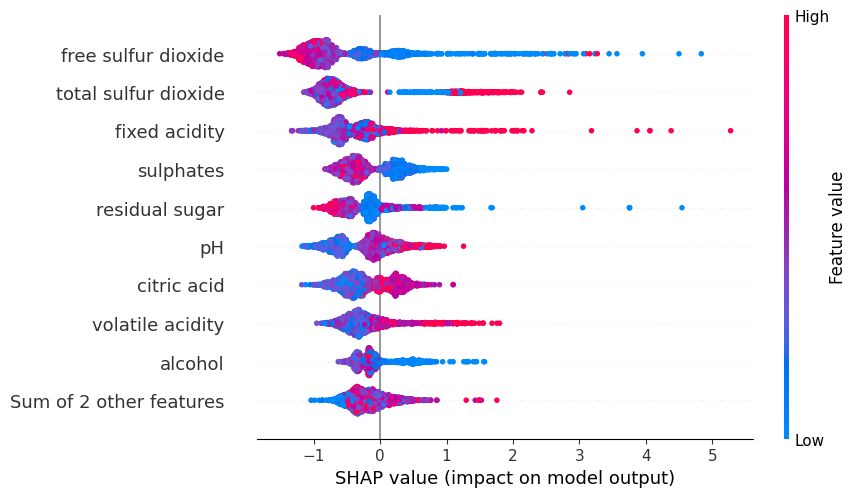

In [73]:
# Initialize the explainer
explainer12 = shap.TreeExplainer(xgb)

# Calculate SHAP values
shap_values12 = explainer12(X_train)

# Access the SHAP values
shap_values_for_class_0 = shap_values12[..., 0]

# Create the beeswarm plot using the single-dimension SHAP values
shap.plots.beeswarm(shap_values_for_class_0)

**Waterfall**

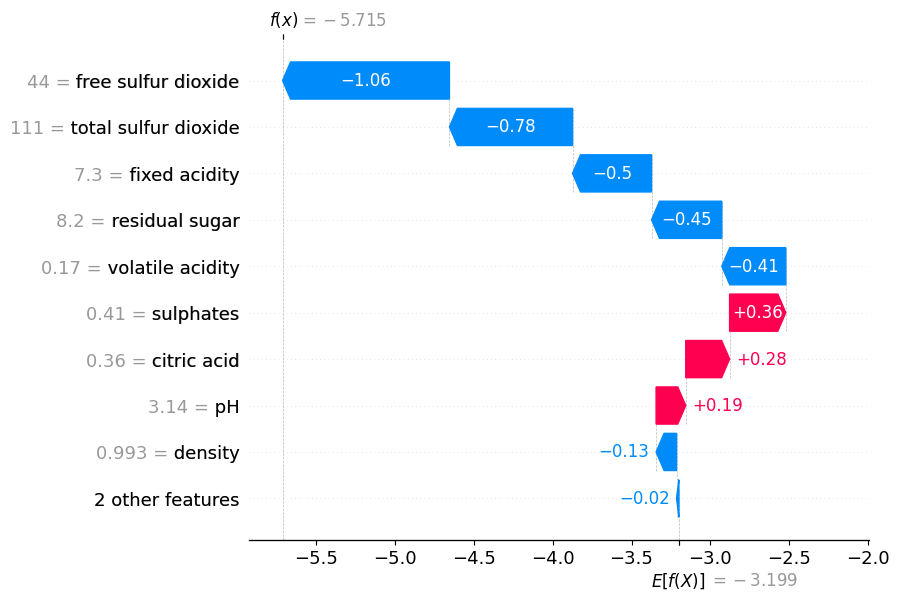

In [74]:
# Select the SHAP values for the first instance and the first class (quality rating 0)
shap_values_for_first_instance_class_0 = shap_values12[0, :, 0]

# Create the waterfall plot
shap.plots.waterfall(shap_values_for_first_instance_class_0)

## interpretation of models

  It seems that across both the Beeswarm and Waterfall models the following features had the most impact on making a good quality wine:

  ### Beeswarm
  1. **fixed acidity**
  2. **citric acid**
  3. **pH**
  4. **volitile acidity**

### Waterfall
  1. **sulfates**
  2. **citric acid**
  3. **pH**

This correlates with the exploratory analysis

**sulfates, citric acid and pH have shown to increase the quality of wine**
